In [31]:
import selfies as sf
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import torch
import torch.nn as nn
import random, glob, os
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem

In [2]:
DATA_DIR = "../multimodal_spectroscopic_dataset"

paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet")))

k = 2
sample_paths = random.sample(paths, k=k)

dfs = []
rows_total = 0

for p in sample_paths:
    df = pd.read_parquet(p)
    dfs.append(df)
    rows_total += len(df)

df = pd.concat(dfs, ignore_index=True)

### Tokenization

In [3]:
df['selfies'] = df['smiles'].apply(sf.encoder)
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def tokens_to_ids(tokens, tok2id):
    return np.array([tok2id[t] for t in tokens])

df['token_ids'] = df['tokens'].apply(lambda toks: tokens_to_ids(toks, tok2id))

### Data prep

In [42]:
sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.zeros((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data
data_tensor = torch.tensor(data)

In [7]:
print(data[1], data.shape)

[34 34 43 34 16 34 22 41 18 27 21 34 34 18 34 18 27 34 36 34 18 45  3 43
 34 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] (6362, 71)


### Baseline Model

In [8]:
class BaselineVAE(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128, latent_size=64):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        self.encoder = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        self.decoder_in = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.output_fc = nn.Linear(hidden_size, vocab_size)

    def encode(self, x):
        _, h = self.encoder(self.embed(x))
        h = h.squeeze(0)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def decode(self, z, max_len=71, start_id=1):
        device = z.device
        batch = z.size(0)

        h = torch.tanh(self.decoder_in(z)).unsqueeze(0)
        token = torch.full((batch, 1), start_id, dtype=torch.long, device=device)

        logits_list = []
        token_ids = []

        for _ in range(max_len):
            emb = self.embed(token)     # [B, 1, E]
            out, h = self.decoder(emb, h)
            logits = self.output_fc(out)

            logits_list.append(logits)
            next_token = torch.argmax(logits, dim=-1)

            token_ids.append(next_token.squeeze(1))
            token = next_token

        logits = torch.cat(logits_list, dim=1)  # [B, T, V]
        return logits, torch.stack(token_ids, dim=1)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(logvar)
        eps = torch.randn_like(std)
        z = mu + std * eps
        logits, tokens = self.decode(z)
        return logits, tokens, mu, logvar
    
    def encode_sequence(self, x):
        device = next(self.parameters()).device
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).long()
        if x.dim() == 1:
            x.unsqueeze(0)
        x = x.to(device)
        self.eval()
        with torch.no_grad():
            logits, tokens, mu, logvar = self(x)
        return logits, tokens, mu, logvar

def vae_loss(logits, x, mu, logvar, beta=0.01):
    B, T, V = logits.shape
    logits_flat = logits.reshape((B*T, V))
    targets_flat = x[:, :T].reshape(B*T)
    rec_loss = F.cross_entropy(logits_flat, targets_flat)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = rec_loss + beta * kl_loss
    return loss, rec_loss, kl_loss

### Training

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = BaselineVAE(vocab_size=len(vocab)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 50
max_len = 100
beta = 0.01
batch_size = 128

loader = DataLoader(data, batch_size, shuffle=True)
history = []

for epoch in range(1, epochs + 1):
    model.train()
    total_recon = 0
    total_kl = 0

    for x in loader:
        x = x.to(device)

        logits, gen_tokens, mu, logvar = model(x)        
        loss, rec, kl = vae_loss(logits, x, mu, logvar, beta=0.01)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_recon += rec.item()
        total_kl += kl.item()
    
    history.append((total_recon / len(loader), total_kl / len(loader)))
    print(f"Epoch {epoch:03d} | recon={total_recon/len(loader):.4f} | KL={total_kl/len(loader):.4f}")


Epoch 001 | recon=2.5196 | KL=0.4682
Epoch 002 | recon=1.3542 | KL=0.3759
Epoch 003 | recon=1.2133 | KL=0.6596
Epoch 004 | recon=1.1923 | KL=0.6879
Epoch 005 | recon=1.1600 | KL=0.6978
Epoch 006 | recon=1.1511 | KL=0.7021
Epoch 007 | recon=1.1478 | KL=0.6848
Epoch 008 | recon=1.1472 | KL=0.6715
Epoch 009 | recon=1.1423 | KL=0.6504
Epoch 010 | recon=1.1412 | KL=0.6424
Epoch 011 | recon=1.1382 | KL=0.6448
Epoch 012 | recon=1.1416 | KL=0.6233
Epoch 013 | recon=1.1355 | KL=0.6157
Epoch 014 | recon=1.1325 | KL=0.6227
Epoch 015 | recon=1.1306 | KL=0.6187
Epoch 016 | recon=1.1336 | KL=0.6217
Epoch 017 | recon=1.1488 | KL=0.6344
Epoch 018 | recon=1.1356 | KL=0.6504
Epoch 019 | recon=1.1229 | KL=0.6456
Epoch 020 | recon=1.1161 | KL=0.6639
Epoch 021 | recon=1.1139 | KL=0.6785
Epoch 022 | recon=1.1083 | KL=0.6895
Epoch 023 | recon=1.1080 | KL=0.7002
Epoch 024 | recon=1.0998 | KL=0.7004
Epoch 025 | recon=1.1039 | KL=0.7046
Epoch 026 | recon=1.0976 | KL=0.7000
Epoch 027 | recon=1.0965 | KL=0.7036
E

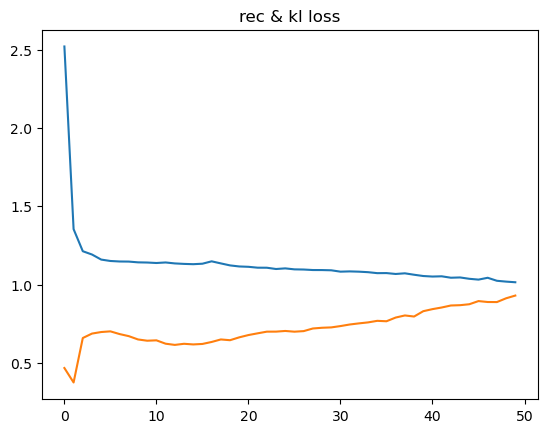

In [23]:
plt.plot(np.array(history)[:, 0])
plt.title('rec & kl loss')
plt.plot(np.array(history)[:, 1])
plt.show()

In [24]:
logits, tokens, mu, logvar = model.encode_sequence(data)
z = mu
z = z.cpu().numpy()

### Visualization

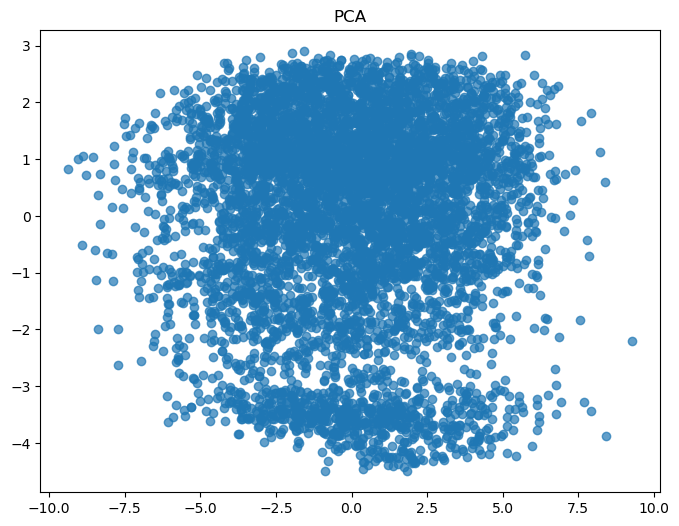

In [25]:
pca_z = PCA(n_components=2).fit_transform(z)
plt.figure(figsize=(8,6))
plt.scatter(pca_z[:, 0], pca_z[:, 1], alpha=0.7)
plt.title('PCA')
plt.show()

[]

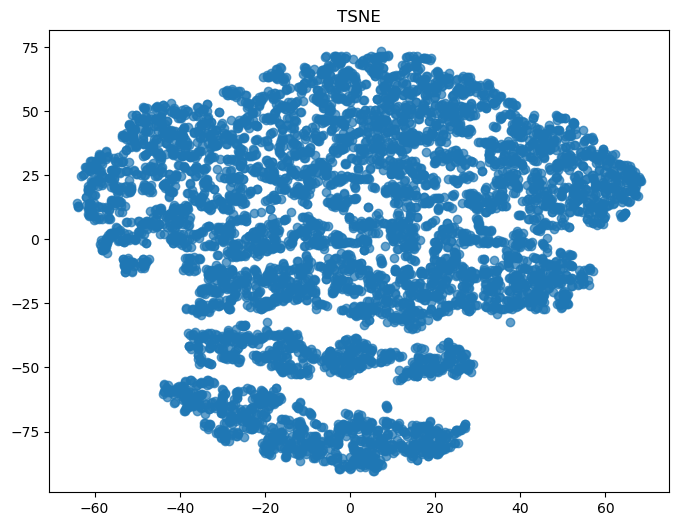

In [30]:
tsne_z = TSNE().fit_transform(z)
plt.figure(figsize=(8,6))
plt.scatter(tsne_z[:, 0], tsne_z[:, 1], alpha=0.7)
plt.title('TSNE')
plt.plot()

### Testing latent

In [26]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

In [27]:
x = data[:1]
print(x.shape)
logits, tokens, mu, logvar = model.encode_sequence(x)
print(tokens_to_selfie(x[0]))
print(tokens_to_selfie(tokens[0]))

(1, 71)
['[C]', '[C]', '[=C]', '[C]', '[Branch1]', '[C]', '[O]', '[=C]', '[C]', '[Branch1]', '[C]', '[Br]', '[=C]', '[Ring1]', '[Branch2]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[Branch1]', '[=C]', '[N]', '[C]', '[=Branch1]', '[C]', '[=O]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '[=C]', '[Ring1]', '[#C]', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[=C]', '[Ring1]', '[Ring1]', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

In [55]:
import random
from Levenshtein import distance as lev_distance  # optional, pip install python-Levenshtein
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, DataStructs

def evaluate_reconstruction_safe(model, dataset, id2tok, tok2id=None,
                                 num_samples=50, max_len=None, verbose=True):
    """
    Evaluate reconstructions robustly: skip unknown ids, drop PAD/SOS/EOS,
    try decode, compute some diagnostics.
    Returns list of result dicts.
    """
    model.eval()
    device = next(model.parameters()).device
    results = []

    # detect special tokens if tok2id provided
    pad_ids = set()
    sos_id = None
    eos_id = None
    if tok2id:
        for special in ["<PAD>", "<SOS>", "<EOS>", "PAD", "SOS", "EOS"]:
            if special in tok2id:
                if special in ("<PAD>", "PAD"):
                    pad_ids.add(tok2id[special])
                if special in ("<SOS>", "SOS"):
                    sos_id = tok2id[special]
                if special in ("<EOS>", "EOS"):
                    eos_id = tok2id[special]

    for _ in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        x = dataset[idx]                 # x is tensor of ids
        x_in = x.unsqueeze(0).to(device)

        # forward
        with torch.no_grad():
            logits, tokens, mu, logvar = model(x_in)

        # input tokens -> SELFIES
        input_ids = x.cpu().tolist()
        in_tokens, _, in_filtered_ids = ids_to_tokens_safe(input_ids, id2tok,
                                                           pad_ids=pad_ids,
                                                           sos_id=sos_id, eos_id=eos_id)
        inp_selfies = tokens_to_selfies(in_tokens)

        inp_smiles, inp_err = safe_decode_selfies(inp_selfies)

        # generated tokens (model output)
        gen_ids = tokens[0].cpu().tolist()
        gen_tokens, stopped, gen_filtered_ids = ids_to_tokens_safe(gen_ids, id2tok,
                                                                   pad_ids=pad_ids,
                                                                   sos_id=sos_id, eos_id=eos_id)
        gen_selfies = tokens_to_selfies(gen_tokens)
        gen_smiles, gen_err = safe_decode_selfies(gen_selfies)

        # compute simple sequence accuracies / lev distance on token ids (filtered)
        # token-level acc: fraction of equal ids up to min length
        match_ratio = None
        lev = None
        tanimoto = None
        try:
            min_len = min(len(in_filtered_ids), len(gen_filtered_ids)) if (in_filtered_ids and gen_filtered_ids) else 0
            if min_len > 0:
                matches = sum(1 for a,b in zip(in_filtered_ids[:min_len], gen_filtered_ids[:min_len]) if a==b)
                match_ratio = matches / min_len
            else:
                match_ratio = 0.0
            # Levenshtein on SELFIES strings if both present
            if inp_selfies and gen_selfies:
                lev = lev_distance(inp_selfies, gen_selfies)
        except Exception:
            pass

        # molecular similarity (if both SMILES decodable)
        if inp_smiles and gen_smiles:
            try:
                mol1 = Chem.MolFromSmiles(inp_smiles)
                mol2 = Chem.MolFromSmiles(gen_smiles)
                if mol1 is not None and mol2 is not None:
                    fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol1, 2, nBits=2048)
                    fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol2, 2, nBits=2048)
                    tanimoto = DataStructs.TanimotoSimilarity(fp1, fp2)
            except Exception:
                tanimoto = None

        results.append({
            "idx": idx,
            "inp_selfies": inp_selfies,
            "gen_selfies": gen_selfies,
            "inp_smiles": inp_smiles,
            "gen_smiles": gen_smiles,
            "inp_err": inp_err,
            "gen_err": gen_err,
            "match_ratio": match_ratio,
            "levenshtein": lev,
            "tanimoto": tanimoto,
            "gen_stopped_at_eos": stopped
        })

        if verbose:
            print("=== sample idx", idx, "===")
            print("input_selfies:", inp_selfies)
            print("gen_selfies  :", gen_selfies)
            print("input_smiles :", inp_smiles, "| err:", inp_err)
            print("gen_smiles   :", gen_smiles, "| err:", gen_err)
            print("token_match_ratio:", match_ratio,
                  "lev:", lev, "tanimoto:", tanimoto, "stopped_eos:", stopped)
            print()

    return results


In [56]:
res = evaluate_reconstruction_safe(model, data_tensor, id2tok)

for i, (s1, s2, sm1, sm2) in enumerate(res[:10]):
    print(f"\nExample {i+1}")
    print("Input SELFIES   :", s1)
    print("Recon SELFIES   :", s2)
    print("Input SMILES    :", sm1)
    print("Recon SMILES    :", sm2)


NameError: name 'ids_to_tokens_safe' is not defined

In [28]:
def evaluate_reconstruction(model, test_loader, vocab, device='cpu', num_examples=5):
    model.eval()
    model.to(device)
    
    reconstruction_accuracies = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            if i >= num_examples:
                break
                
            x = batch.to(device)
            logits, reconstructed, mu, logvar = model(x)
            
            # Convert logits to token predictions
            pred_tokens = torch.argmax(logits, dim=-1)
            
            # Calculate accuracy (ignoring padding tokens)
            mask = (x != 0)  # Padding tokens are 0
            accuracy = ((pred_tokens == x) & mask).float().sum() / mask.float().sum()
            reconstruction_accuracies.append(accuracy.item())
            
            # Print examples
            print(f"\nExample {i+1}:")
            print(f"Original:    {x[0].cpu().numpy()}")
            print(f"Reconstructed: {pred_tokens[0].cpu().numpy()}")
            print(f"Accuracy: {accuracy.item():.4f}")
    
    print(f"\nAverage reconstruction accuracy: {np.mean(reconstruction_accuracies):.4f}")
    return reconstruction_accuracies


def interpolate_molecules(model, z1, z2, steps=10, device='cpu'):
    """Interpolate between two points in latent space"""
    model.eval()
    model.to(device)
    
    alphas = torch.linspace(0, 1, steps, device=device)
    interpolated_sequences = []
    
    with torch.no_grad():
        for alpha in alphas:
            z = alpha * z1 + (1 - alpha) * z2
            logits, tokens = model.decode(z.unsqueeze(0))
            interpolated_sequences.append(tokens.squeeze(0).cpu().numpy())
    
    return interpolated_sequences

# Example usage
def show_interpolation(model, data_loader, device='cpu'):
    # Get two random molecules
    data_iter = iter(data_loader)
    x1, x2 = next(data_iter)[0][:2].to(device)
    
    with torch.no_grad():
        z1, _ = model.encode(x1.unsqueeze(0))
        z2, _ = model.encode(x2.unsqueeze(0))
    
    interpolated = interpolate_molecules(model, z1.squeeze(0), z2.squeeze(0))
    
    print("Interpolation from molecule 1 to molecule 2:")
    for i, seq in enumerate(interpolated):
        print(f"Step {i}: {seq}")

def generate_novel_molecules(model, num_samples=10, latent_size=64, device='cpu'):
    """Generate new molecules by sampling from prior distribution"""
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        # Sample from standard normal (prior)
        z = torch.randn(num_samples, latent_size, device=device)
        logits, tokens = model.decode(z)
    
    generated_sequences = tokens.cpu().numpy()
    
    print("Generated molecules:")
    for i, seq in enumerate(generated_sequences):
        print(f"Molecule {i+1}: {seq}")
    
    return generated_sequences

In [29]:
# Assuming you have your model and data loader
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. Evaluate reconstruction
accuracies = evaluate_reconstruction(model, loader, vocab, device)


Example 1:
Original:    [34 34 18 34 34 34 34 16 34 22 43 34 16 34 22 34 45 43 45  3  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Reconstructed: [34 34 16 34 22 34 34 34 34 34 34 34 34 34 34 34 34 45 16  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Accuracy: 0.4168

Example 2:
Original:    [43 25 16 34 22 34 34 21 34 18 41 18 45 16 34 27 34 43 18 45 41 34 18 34
 27 34 35 18 34 18 45  3 34 27 34 36 27 34 36 36  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Reconstructed: [43 34 18 34 18 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34 34 34 34 34 34 34 45 45  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Accuracy: 0.4256

Example 3:
Origin

In [126]:
novel_molecules = generate_novel_molecules(model, num_samples=5, device=device)

Generated molecules:
Molecule 1: [34 34 18 27 34 34 34 34 18 34 18 34 34 34 34 34 34 34 34 34 34 34 34 34
 18 18 18 34 18 18 18 27 27 34 36 18 18 46 46 46  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Molecule 2: [34 34 34 34 34 34 18 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34
 34 34 34 34 34 34 34 34 34 34 27 34 34 34 34 34 34 34 18 46 46  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Molecule 3: [34 34 18 34 18 34 18 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 34 27
 34 34 34 34 34 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Molecule 4: [34 34 18 34 18 27 34 34 34 34 34 34 34 34 34 34 34 34 27 34 34 34 34 34
 34 34 34 34 46 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Molecule 5: [34 34 27 34 34 44 34 34 34 34 34 34 34 34 34 34 34